In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.cluster import KMeans

In [30]:
TEXT_COLOR = '#313131'
LINE_COLORS = ['#00A082', '#F2CC38', '#9B59B6', '#3498DB', '#F39C12']

sns.set(
    style='darkgrid', 
    rc={'figure.figsize':(6,4),
        'figure.dpi': 120,
        'figure.facecolor': 'w', 
        'legend.facecolor': 'w',
        'text.color': TEXT_COLOR,
        'font.family': 'Microsoft Sans Serif', # 'Open Sans',
        'axes.labelcolor': TEXT_COLOR,
        'xtick.color': TEXT_COLOR,
        'ytick.color': TEXT_COLOR}
)

sns.set_palette(sns.color_palette(LINE_COLORS))

# Load the data

In [7]:
data = pd.read_csv('../data/house-prices-dataset/train.csv')

In [8]:
# Selecting top-predictor columns IMO
cols = [
    'OverallQual', 
    'GrLivArea',
    'ExterQual',
    'GarageCars',
    'YearBuilt',
    'YearRemodAdd',
    'TotRmsAbvGrd',
    'Foundation',
    'Fireplaces',
    'FireplaceQu',
    'HeatingQC',
    'SalePrice'
]

In [9]:
data = data[cols]

In [10]:
def col_to_dummies(df, col):
    return pd.concat(
        [data, pd.get_dummies(data[col], prefix=col, drop_first=True)], 
        axis=1
    ).drop(col, axis=1)

In [11]:
data['FireplaceQu'] = data['FireplaceQu'].map({
    np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5
})

In [12]:
data['HeatingQC'] = data['HeatingQC'].map({
    'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4
})

In [13]:
data['ExterQual'] = data['ExterQual'].map({
    'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4
})

In [14]:
data = col_to_dummies(data, 'Foundation')

## Apply k-means to raw data

In [23]:
km = KMeans(n_clusters=3, random_state=42)

In [24]:
km.fit(data)

KMeans(n_clusters=3, random_state=42)

In [25]:
data['cluster'] = km.labels_

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

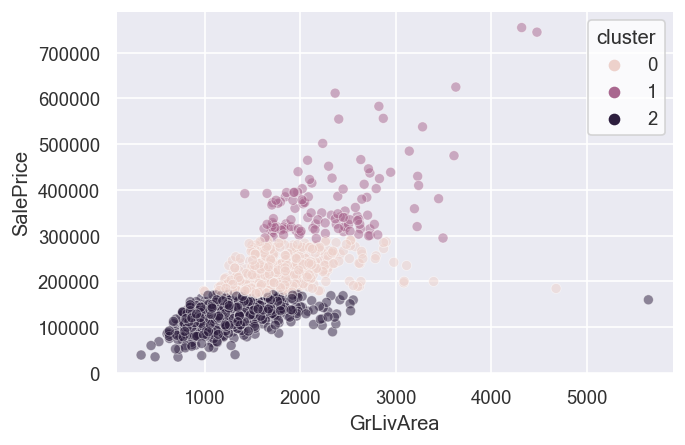

In [32]:
sns.scatterplot(data=data, x='GrLivArea', y='SalePrice', hue='cluster', alpha=0.5)

Seems like price was the most decisive factor to assign clusters because it is of large numbers.

### Apply to scaled data

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()

In [39]:
scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [41]:
km = KMeans(n_clusters=3, random_state=42)

In [42]:
km.fit(scaled)

KMeans(n_clusters=3, random_state=42)

In [43]:
scaled['cluster'] = km.labels_

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

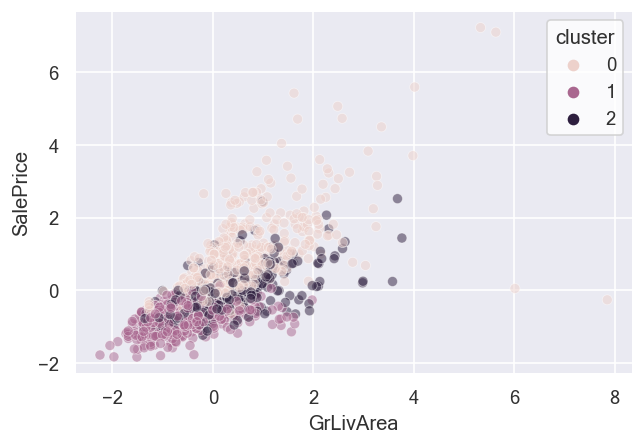

In [45]:
sns.scatterplot(data=scaled, x='GrLivArea', y='SalePrice', hue='cluster', alpha=0.5)

### Use k-means clusters as feature in a model

---